# Project

## Importing modules

In [1]:
!pip install torchinfo --quiet
!pip install bayesian-torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
import random
import gzip
import pickle
import zipfile
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms, models
from torchinfo import summary
from matplotlib import pyplot as plt
from google.colab import drive, files
from collections import Counter
from PIL import Image

import torch.nn as nn
import bayesian_torch as bt
import torch.optim as optim
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setting seed

In [3]:
# Set the seed for PyTorch
torch.manual_seed(1405)

# Set the seed for NumPy
np.random.seed(1405)

# Set the seed for Python's built-in random library
random.seed(1405)

# If using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(1405)
    torch.cuda.manual_seed_all(1405)  # if you are using multi-GPU.

# Generic functions

The functions and classes here are taken from lab 5 with all the junk removed. They (should) work for any dataset.

In [4]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [5]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [7]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()  # ChatGPT says opt.zero_grad should be first not last?
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [8]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

In [9]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)  # reduces with factor of 10 every 10 epochs

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            # Move input data to the same device as the model
            xb = xb.to(device)
            yb = yb.to(device)

            # Unpack the loss and other outputs
            loss, _ = loss_batch(model, loss_func, xb, yb, opt)
            total_loss += loss
            preds = model(xb).argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss_total, val_correct = 0.0, 0
            val_samples = 0
            for xb, yb in valid_dl:
                # Move input data to the same device as the model
                xb = xb.to(device)
                yb = yb.to(device)

                # Get validation loss
                val_loss, _ = loss_batch(model, loss_func, xb, yb)

                val_loss_total += val_loss
                preds = model(xb).argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

            val_loss_avg = val_loss_total / len(valid_dl)
            val_acc = val_correct / val_samples

        scheduler.step()

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss function
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Function that loads model if it exists otherwise trains

In [11]:
def load_or_train_model(model_path, epochs, model, loss_func, opt, train_dl, val_dl):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    try:
        # Load the pre-trained model
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        # Train the model if no saved model exists
        print(f"Model not found at {model_path}, starting training.")
        fit(epochs, model, loss_func, opt, train_dl, val_dl)
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

# Loading German traffic signs

In [12]:
# Path to your ZIP file in Google Drive
zip_file_path = '/content/gdrive/MyDrive/German-traffic-signs/archive.zip'

# Create a directory to extract the contents if it doesn't exist
extract_path = '/content/gtsrb'
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['Test.csv', 'Test', 'Meta', 'train', 'meta', 'Train.csv', 'test', 'Meta.csv', 'Train']


**Define transformation and load into train, test and valdiadation set.**

Note that the test files the classes are hidden. So we just take train files and randomly split into train, test and validation set. Can be confirmed by running this code



```
# Check the contents of the train and test folders
train_files = os.listdir('/content/gtsrb/train')
test_files = os.listdir('/content/gtsrb/test')
print("Train folders:", train_files)
print("Test folders:", test_files)
```



In [13]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
])

# Load the dataset and transform
full_dataset = datasets.ImageFolder(
    root='/content/gtsrb/train',
    transform=transform
)

# Check the total number of samples in the dataset
total_samples = len(full_dataset)
print(f"Total samples in the dataset: {total_samples}")

# Get the first image and its label from the dataset
image, label = full_dataset[0]

# Check the shape of the image tensor
print(f"Shape of the first image: {image.shape}")
print(f"Label of the first image: {label}")

Total samples in the dataset: 39209
Shape of the first image: torch.Size([3, 160, 160])
Label of the first image: 0


In [14]:
# Get the labels for all samples in the dataset
labels = [label for _, label in full_dataset]

# Count the occurrences of each label
class_distribution = Counter(labels)

# Print the class distribution
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

Class 0: 210 samples
Class 1: 2220 samples
Class 2: 2010 samples
Class 3: 1320 samples
Class 4: 2100 samples
Class 5: 2160 samples
Class 6: 780 samples
Class 7: 630 samples
Class 8: 420 samples
Class 9: 1110 samples
Class 10: 1200 samples
Class 11: 210 samples
Class 12: 2250 samples
Class 13: 360 samples
Class 14: 330 samples
Class 15: 390 samples
Class 16: 510 samples
Class 17: 270 samples
Class 18: 1500 samples
Class 19: 600 samples
Class 20: 240 samples
Class 21: 540 samples
Class 22: 270 samples
Class 23: 1410 samples
Class 24: 450 samples
Class 25: 780 samples
Class 26: 240 samples
Class 27: 689 samples
Class 28: 420 samples
Class 29: 1200 samples
Class 30: 390 samples
Class 31: 210 samples
Class 32: 2070 samples
Class 33: 300 samples
Class 34: 1980 samples
Class 35: 360 samples
Class 36: 240 samples
Class 37: 240 samples
Class 38: 1860 samples
Class 39: 420 samples
Class 40: 1440 samples
Class 41: 1410 samples
Class 42: 1470 samples


Now we split this into 70% train, 15% validation and 15% test.

In [15]:
# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the lengths for each split
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 27446, Validation size: 5881, Test size: 5882


In [16]:
# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [17]:
# Set the batch size
bs = 64

# Create DataLoaders. A dataloader provides an efficient way to iterate over your dataset during training
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=bs * 2, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=bs * 2, shuffle=False)

## Dataset summary

Show how many classes we have in dataset:

In [18]:
# Get the number of classes from the original dataset (full_dataset)
num_classes = len(full_dataset.classes)

# Print the number of classes
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 43


43 classes

## Visualize the classes

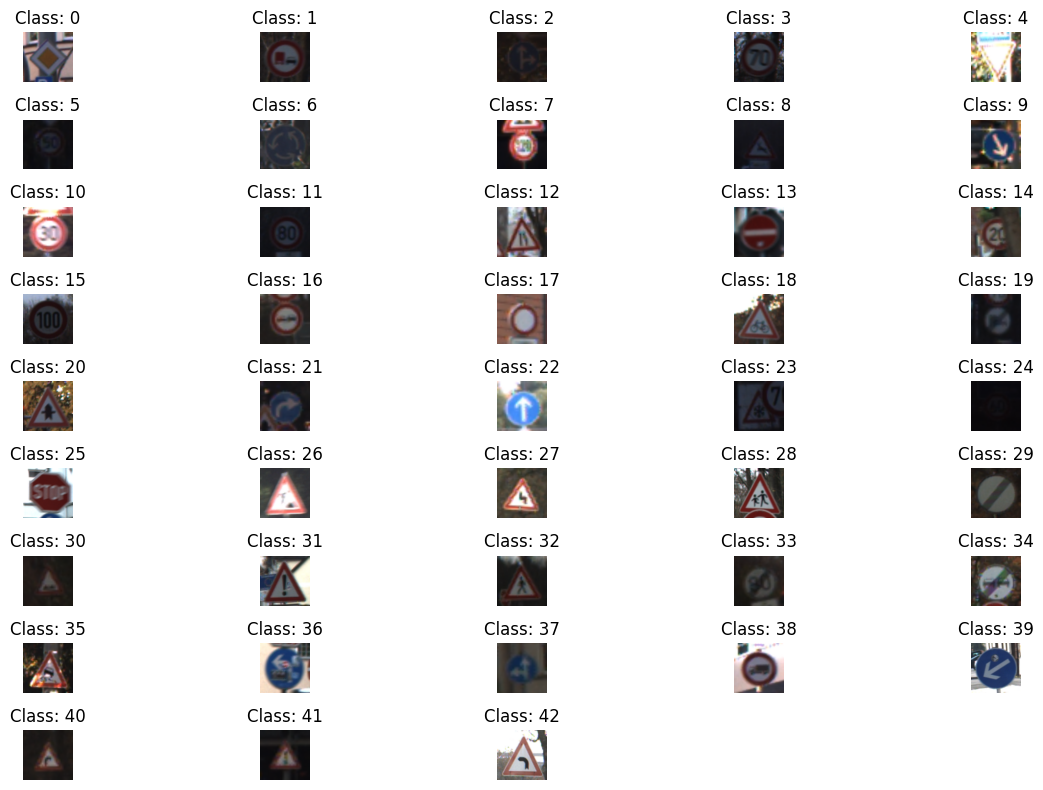

In [19]:
# Function to show images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  # Undo normalization
    img = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert to HWC format
    plt.axis('off')  # Hide axis

# Create a dictionary to keep track of images displayed for each class
class_count = {i: 0 for i in range(num_classes)}

# Store images and labels
ordered_images = []
ordered_labels = []

# Get images until one for each class is found
while len(ordered_images) < num_classes:
    dataiter = iter(train_dl)  # Reset the iterator for each pass
    images, labels = next(dataiter)

    # Loop through the images to find and store one per class
    for i in range(len(images)):
        label = labels[i].item()

        # Check if we have already stored an image for this class
        if class_count[label] < 1:  # Change to images_per_class if needed
            ordered_images.append(images[i])  # Store the image
            ordered_labels.append(label)  # Store the label
            class_count[label] += 1  # Increment count for this class

# Plot the images and their corresponding labels in order
ordered_labels = np.sort(ordered_labels)
plt.figure(figsize=(12, 8))
num_images_per_row = 5  # Maximum images per row

# Loop to display images in order
for i, (img, label) in enumerate(zip(ordered_images, ordered_labels)):
    plt.subplot((num_classes + num_images_per_row - 1) // num_images_per_row, num_images_per_row, i + 1)
    imshow(img)
    plt.title(f'Class: {label}')

plt.tight_layout()
plt.show()





## Baseline model

In [ ]:
baseline_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),#Used to flatten he output
    #nn.Flatten(), # Flatten the output for the linear layer
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



In [ ]:
summary(baseline_model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─ReLU: 1-2                              [1, 16, 80, 80]           --
├─Conv2d: 1-3                            [1, 32, 40, 40]           4,640
├─ReLU: 1-4                              [1, 32, 40, 40]           --
├─Conv2d: 1-5                            [1, 64, 20, 20]           18,496
├─ReLU: 1-6                              [1, 64, 20, 20]           --
├─AdaptiveAvgPool2d: 1-7                 [1, 64, 1, 1]             --
├─Lambda: 1-8                            [1, 64]                   --
├─Linear: 1-9                            [1, 43]                   2,795
Total params: 26,379
Trainable params: 26,379
Non-trainable params: 0
Total mult-adds (M): 17.69
Input size (MB): 0.31
Forward/backward pass size (MB): 1.43
Params size (MB): 0.11
Estimated Total Size (MB): 1.85

### Train baseline model

In [ ]:
baseline_model.to(dev)
lr = 0.01
epochs = 5
loss_func = F.cross_entropy
opt = torch.optim.SGD(baseline_model.parameters(), lr=lr)
# opt = torch.optim.Adam(baseline_model.parameters(), lr=lr) # Adam optimizer

The output is the loss.

<ipython-input-11-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model not found at /content/gdrive/MyDrive/German-traffic-signs/baseline_model.pth, starting training.
Epoch 1/5 - Train Loss: 3.7230, Train Acc: 0.0562 - Val Loss: 3.6371, Val Acc: 0.0593
Epoch 2/5 - Train Loss: 3.5181, Train Acc: 0.0627 - Val Loss: 3.4741, Val Acc: 0.0687
Epoch 3/5 - Train Loss: 3.4753, Train Acc: 0.0736 - Val Loss: 3.4586, Val Acc: 0.0748
Epoch 4/5 - Train Loss: 3.4505, Train Acc: 0.0840 - Val Loss: 3.4314, Val Acc: 0.0804
Epoch 5/5 - Train Loss: 3.4249, Train Acc: 0.0866 - Val Loss: 3.4116, Val Acc: 0.0794


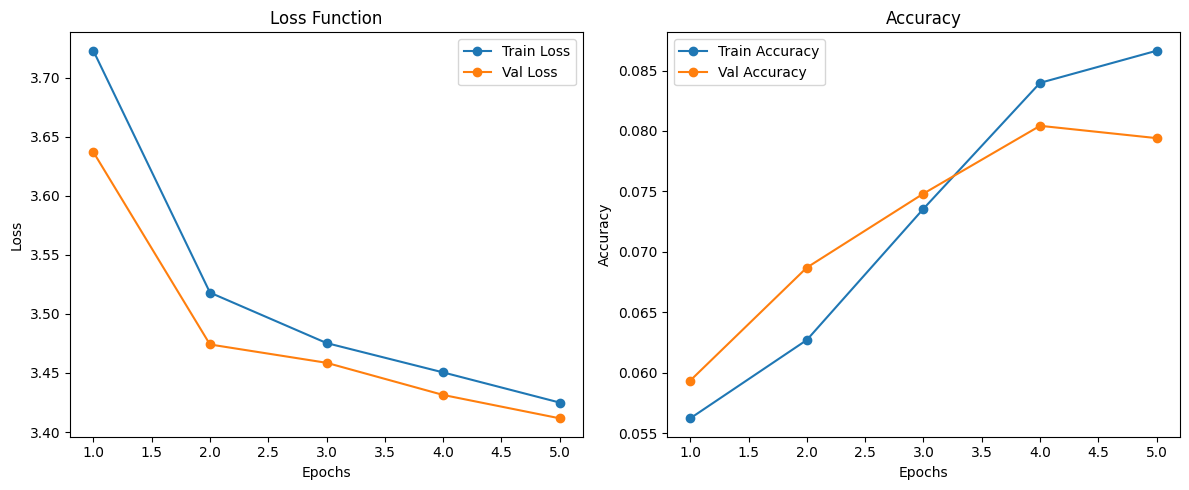

Model saved to /content/gdrive/MyDrive/German-traffic-signs/baseline_model.pth


In [ ]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/baseline_model.pth'
load_or_train_model(path_model, epochs, baseline_model, loss_func, opt, train_dl, val_dl)

### Visualize some predictions

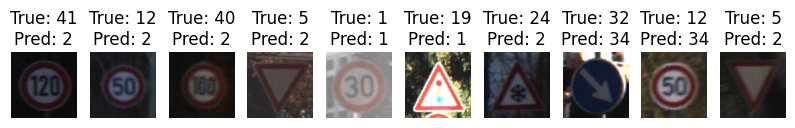

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Lambda()
  (8): Linear(in_features=64, out_features=43, bias=True)
)

In [ ]:
def denormalize(img):
    img = img / 2 + 0.5  # assuming the images were normalized to [-1, 1]
    return img.clamp(0, 1)  # clamp values to [0, 1]

# Modified show_images function with denormalization
def show_images(images, labels, preds, num_images=10):
    images = denormalize(images)  # Denormalize before displaying
    plt.figure(figsize=(10, 10))

    # Limit to the specified number of images (default is 5)
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Assuming images are in [C, H, W] format
        plt.title(f'True: {labels[i]}\nPred: {preds[i]}')
        plt.axis('off')
    plt.show()

# Get a batch of validation images
baseline_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = baseline_model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# Revert model back to training mode
baseline_model.train()

## Data augmentation

Consider adding some data augmentation

## Better model (batch normalization, dropout, bigger model)

In [46]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout applied here for the dense layer

    nn.Linear(128, num_classes)
)

In [47]:
summary(model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─BatchNorm2d: 1-2                       [1, 16, 80, 80]           32
├─ReLU: 1-3                              [1, 16, 80, 80]           --
├─Conv2d: 1-4                            [1, 32, 40, 40]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 40, 40]           64
├─ReLU: 1-6                              [1, 32, 40, 40]           --
├─Conv2d: 1-7                            [1, 64, 20, 20]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 20, 20]           128
├─ReLU: 1-9                              [1, 64, 20, 20]           --
├─Conv2d: 1-10                           [1, 128, 10, 10]          73,856
├─BatchNorm2d: 1-11                      [1, 128, 10, 10]          256
├─ReLU: 1-12                             [1, 128, 10, 10]          --
├



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



### Train model

In [48]:
model.to(dev)
lr = 0.01
epochs = 20
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

<ipython-input-11-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model not found at /content/gdrive/MyDrive/German-traffic-signs/model.pth, starting training.
Epoch 1/20 - Train Loss: 3.0939, Train Acc: 0.1387 - Val Loss: 2.9213, Val Acc: 0.1789
Epoch 2/20 - Train Loss: 2.4250, Train Acc: 0.2532 - Val Loss: 2.3625, Val Acc: 0.3030
Epoch 3/20 - Train Loss: 1.9161, Train Acc: 0.3767 - Val Loss: 1.5347, Val Acc: 0.4686
Epoch 4/20 - Train Loss: 1.5693, Train Acc: 0.4822 - Val Loss: 1.0439, Val Acc: 0.6438
Epoch 5/20 - Train Loss: 1.1804, Train Acc: 0.6149 - Val Loss: 0.6718, Val Acc: 0.7915
Epoch 6/20 - Train Loss: 0.8923, Train Acc: 0.7041 - Val Loss: 0.4677, Val Acc: 0.8626
Epoch 7/20 - Train Loss: 0.7117, Train Acc: 0.7649 - Val Loss: 0.2779, Val Acc: 0.9213
Epoch 8/20 - Train Loss: 0.6006, Train Acc: 0.8042 - Val Loss: 0.2413, Val Acc: 0.9308
Epoch 9/20 - Train Loss: 0.5378, Train Acc: 0.8250 - Val Loss: 0.1690, Val Acc: 0.9595
Epoch 10/20 - Train Loss: 0.4722, Train Acc: 0.8493 - Val Loss: 0.1336, Val Acc: 0.9617
Epoch 11/20 - Train Loss: 0.3794, T

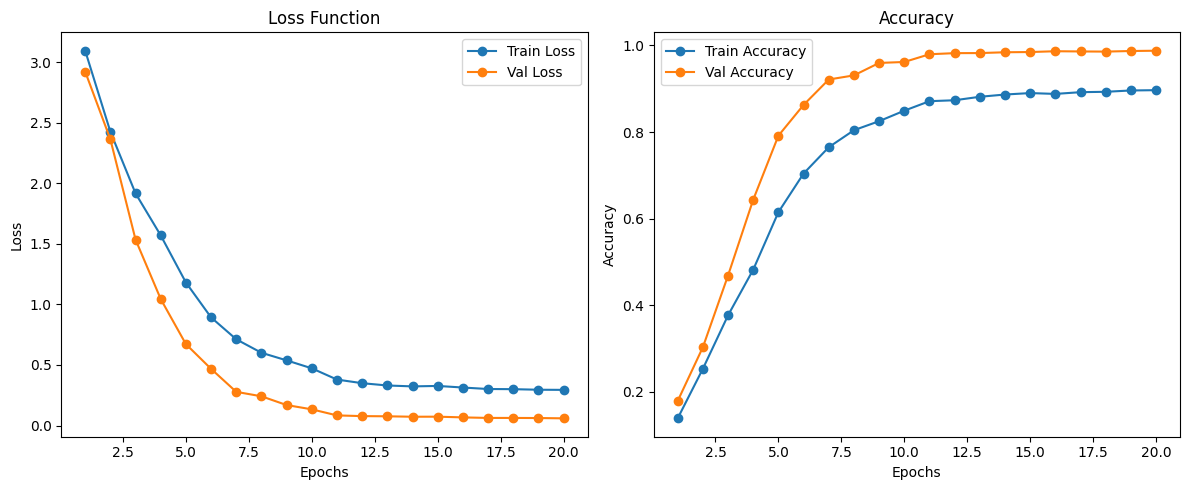

Model saved to /content/gdrive/MyDrive/German-traffic-signs/model.pth


In [ ]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model.pth'
load_or_train_model(path_model, epochs, model, loss_func, opt, train_dl, val_dl)

# fit(epochs, model, loss_func, opt, train_dl, val_dl)

### Visualize some predictions

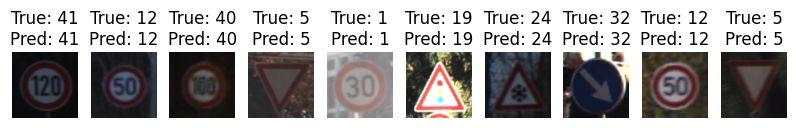

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AdaptiveAvgPool2d(output_size=1)
  (16): Lambda()
  (17): Linear(in_features=256, out_features=128, b

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# revert model back to train mode
model.train()

## Transfer learning

We use the ResNet50 pre-trained on ImageNet for transfer learning

In [ ]:
# Load ResNet50 pre-trained on ImageNet
model_transfer = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
model_transfer.to(dev)
lr = 0.01
epochs = 5
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_transfer.parameters(), lr=lr) # Adam optimizer

<ipython-input-11-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model not found at /content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth, starting training.
Epoch 1/5 - Train Loss: 0.8866, Train Acc: 0.7964 - Val Loss: 0.5163, Val Acc: 0.8310
Epoch 2/5 - Train Loss: 0.3608, Train Acc: 0.9153 - Val Loss: 0.4884, Val Acc: 0.8492
Epoch 3/5 - Train Loss: 0.3075, Train Acc: 0.9288 - Val Loss: 0.4632, Val Acc: 0.8616
Epoch 4/5 - Train Loss: 0.2709, Train Acc: 0.9379 - Val Loss: 0.5057, Val Acc: 0.8572
Epoch 5/5 - Train Loss: 0.2408, Train Acc: 0.9469 - Val Loss: 0.4667, Val Acc: 0.8698


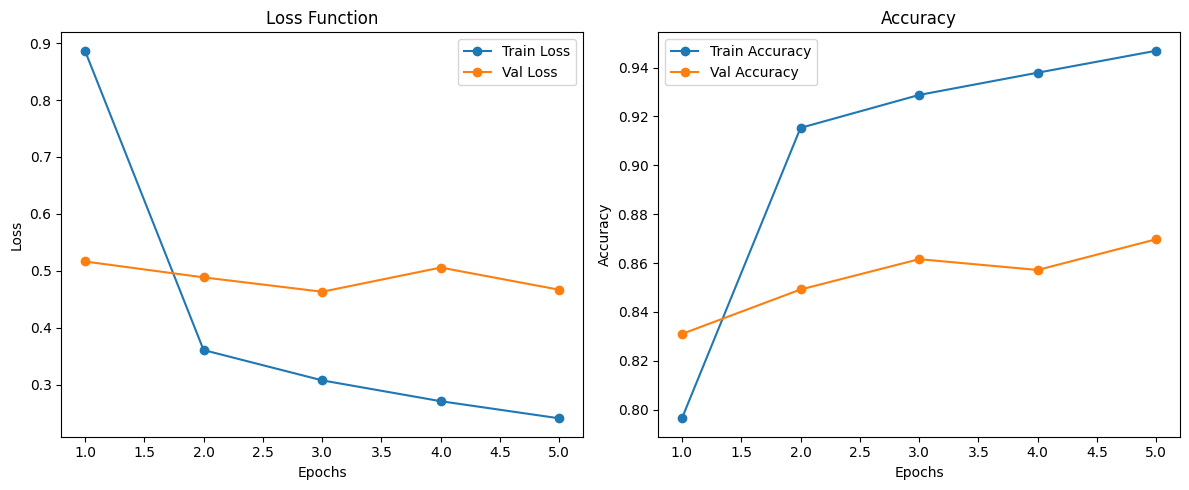

Model saved to /content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth


In [ ]:
transfer_model_path = '/content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth'
load_or_train_model(
    transfer_model_path,
    epochs, model_transfer,
    loss_func,
    opt,
    train_dl,
    val_dl
)

The transfer learning training is really slow

# Bayesian CNN



We will now also train a bayesian CNN. We will (for now) do it by doing Bayes by Backprop (BBB)

See chapter 5 in Enhancing deep learning with bayesian inference. Code for the example is given here: https://github.com/PacktPublishing/Enhancing-Deep-Learning-with-Bayesian-Inference/tree/main/ch05/bbb

(Maybe a library already exists so less code needed?)

### Using MC dropout

#### Visualize predictions

In [20]:
def visualize_mc_dropout_single_image(model, val_dl, num_samples=10, top_k=3):
    model.train()  # Set to train mode to keep dropout active
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        # Get a single batch of images and labels
        images, labels = next(iter(val_dl))
        images, labels = images.to(device), labels.to(device)

        # Select only the first image in the batch for demonstration
        single_image = images[0].unsqueeze(0)
        single_label = labels[0].unsqueeze(0)

        # Run MC dropout multiple times and store the top-k predictions
        all_probs = []
        all_classes = []
        for _ in range(num_samples):
            output = model(single_image)  # Forward pass with dropout active
            prob = F.softmax(output, dim=1)  # Apply softmax for probabilities
            top_probs, top_classes = torch.topk(prob, top_k, dim=1)  # Get top-k predictions
            all_probs.append(top_probs.squeeze())
            all_classes.append(top_classes.squeeze())

        # Display the same image with predictions from multiple MC dropout samples
        single_image = denormalize(single_image.squeeze())  # Denormalize image for display
        plt.figure(figsize=(15, 15))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(single_image.permute(1, 2, 0).cpu().numpy())  # Convert [C, H, W] to [H, W, C]
            plt.title("Top Predictions:\n" +
                      "\n".join([f"Class {int(cls)}: {float(prob):.2f}"
                                 for cls, prob in zip(all_classes[i], all_probs[i])]))
            plt.axis("off")
        plt.suptitle(f"MC Dropout Predictions for the Same Image - True Class: {single_label.item()}")
        plt.show()

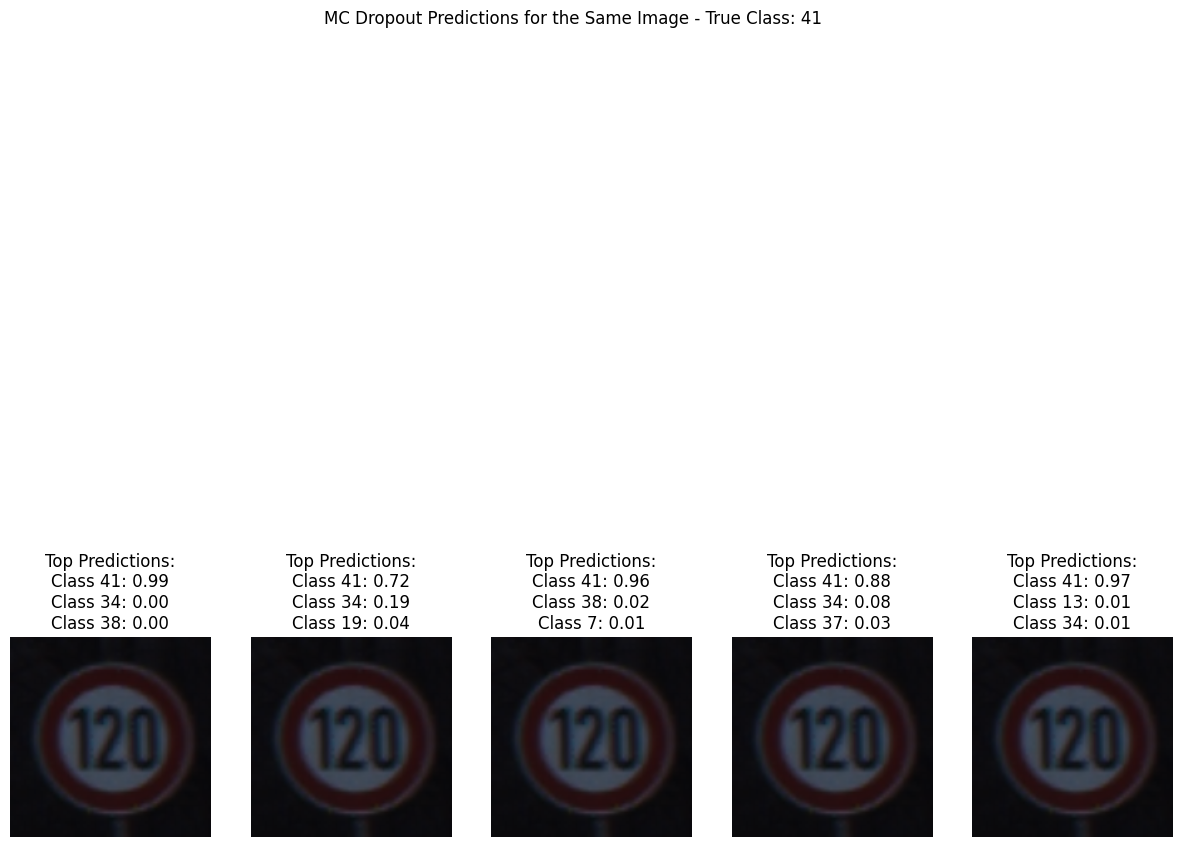

In [ ]:
visualize_mc_dropout_single_image(model, val_dl, num_samples=5, top_k=3)

#### Evaluate

In [21]:
def evaluate_mc_dropout(model, data_loader, num_samples=100):
    model.train()  # Ensure dropout is active
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_loss, total_correct = 0.0, 0
    total_samples = 0
    variances = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)

            # Collect logits over multiple dropout samples
            logits_list = [model(xb) for _ in range(num_samples)]
            logits_stack = torch.stack(logits_list)  # Shape: (num_samples, batch_size, num_classes)

            # Compute mean logits and use for loss and accuracy
            logits_mean = logits_stack.mean(dim=0)
            loss = F.cross_entropy(logits_mean, yb)
            total_loss += loss.item()

            # Calculate probability variance by applying softmax on each sample's logits
            preds_list = [torch.softmax(logits, dim=1) for logits in logits_list]
            preds_stack = torch.stack(preds_list)  # Shape: (num_samples, batch_size, num_classes)
            preds_var = preds_stack.var(dim=0)
            variances.append(preds_var.mean().item())  # Average variance of probabilities for batch

            # Compute accuracy using the mean logits
            preds = logits_mean.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    avg_variance = sum(variances) / len(variances)

    return avg_loss, accuracy, avg_variance

In [ ]:
avg_loss, accuracy, avg_variance = evaluate_mc_dropout(model, val_dl, num_samples = 100)

In [ ]:
print(f"Evaluation Results:\n"
      f"-------------------\n"
      f"Average Loss: {avg_loss:.4f}\n"
      f"Accuracy: {accuracy:.4f}\n"
      f"Average Variance: {avg_variance:.4f}")

Evaluation Results:
-------------------
Average Loss: 0.0615
Accuracy: 0.9878
Average Variance: 0.0024


In [ ]:
# avg_loss_1000, accuracy_1000, avg_variance_1000 = evaluate_mc_dropout(model_mc_dropout, val_dl, num_samples = 1000)

In [ ]:
#print(f"Evaluation Results:\n"
#      f"-------------------\n"
#      f"Average Loss: {avg_loss_1000:.4f}\n"
#      f"Accuracy: {accuracy_1000:.4f}\n"
#      f"Average Variance: {avg_variance_1000:.4f}")

Almost the same if 1000 or 100 but 100 samples much faster.

### Using bayesian-torch

See their github page and their examples on how to run bayesian-torch https://github.com/IntelLabs/bayesian-torch.

#### Functions

Making the code in the github for bayesian-torch into functions:

In [22]:
# Function to calculate variance across model predictions
def predictive_variance(mc_preds):
    """
    Compute the variance of the predictive distribution
    obtained from Monte Carlo sampling during prediction phase.
    """
    return np.var(mc_preds, axis=0).mean(axis=-1)  # Average variance across classes per sample

# Accuracy calculation for Bayesian CNN
def calculate_accuracy_mc(output_mc_tensor, y_true):
    # Average the predictions over all MC runs
    avg_probs = output_mc_tensor.mean(dim=0)  # (batch_size, num_classes)
    _, predicted = torch.max(avg_probs, dim=1)  # Get the predicted class from averaged probabilities
    correct_predictions = (predicted == y_true).sum().item()  # Count correct predictions
    accuracy = correct_predictions / y_true.size(0)  # Compute accuracy as a fraction
    return accuracy


In [23]:
# Training function for Bayesian CNN
# Says not enough memory if trying to get accuracy using MC during train
def train_bnn(model, train_loader, criterion, optimizer, device, args):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_samples = 0

    # Define a learning rate scheduler, e.g., StepLR with step_size and gamma
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        optimizer.zero_grad()  # Clear the gradients
        output = model(x_train)  # Forward pass

        kl = get_kl_loss(model)  # KL divergence loss
        ce_loss = criterion(output, y_train)  # Cross-entropy loss
        loss = ce_loss + kl / y_train.size(0)  # Total loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        total_loss += loss.item()

        total_samples += y_train.size(0)
    # Step the scheduler at the end of each epoch
    scheduler.step()

    average_loss = total_loss / len(train_loader)
    return average_loss

# Validation function for Bayesian CNN
# Function to calculate variance across model predictions
def predictive_variance(mc_preds):
    """
    Compute the variance of the predictive distribution
    obtained from Monte Carlo sampling during prediction phase.
    """
    return np.var(mc_preds, axis=0).mean(axis=-1)  # Average variance across classes per sample

# Validation function for Bayesian CNN
def evaluate_bnn(model, val_loader, criterion, device, args):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_y_true = []
    variance_list = []  # List to accumulate variances for each batch

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Collect raw outputs (logits) for each Monte Carlo run
            outputs_mc = []
            for mc_run in range(args.num_monte_carlo):
                raw_output = model(x_val)  # Raw output (logits) from model
                outputs_mc.append(raw_output)

            # Stack raw outputs along the first dimension (num_monte_carlo, batch_size, num_classes)
            outputs_mc_tensor = torch.stack(outputs_mc)  # Shape: (num_monte_carlo, batch_size, num_classes)

            # Calculate softmax for each Monte Carlo run
            probs_mc = [F.softmax(raw_output, dim=-1) for raw_output in outputs_mc]
            probs_mc_tensor = torch.stack(probs_mc)  # Shape: (num_monte_carlo, batch_size, num_classes)

            # Calculate the mean of probabilities for loss and accuracy
            probs_mean = probs_mc_tensor.mean(dim=0)  # Shape: (batch_size, num_classes)

            # Compute negative log-likelihood loss using the mean probabilities
            # We use NLLLoss, which expects log probabilities, so we take the log of the mean probabilities
            log_probs_mean = torch.log(probs_mean)
            ce_loss = F.nll_loss(log_probs_mean, y_val)
            total_loss += ce_loss.item()
            total_samples += y_val.size(0)

            # Calculate predicted class by taking the argmax of the mean probabilities
            y_pred = torch.argmax(probs_mean, dim=-1)
            all_preds.extend(y_pred.cpu().numpy())  # Collect predictions for the entire validation set
            all_y_true.extend(y_val.cpu().numpy())

            # Calculate predictive variance for the batch (variance of probabilities)
            pred_variance = probs_mc_tensor.var(dim=0)  # Variance across MC samples
            variance_list.append(pred_variance.mean().item())  # Average variance for this batch

    # Calculate overall accuracy on validation
    accuracy = (np.array(all_preds) == np.array(all_y_true)).mean()
    average_loss = total_loss / len(val_loader)
    avg_pred_variance = np.mean(variance_list)  # Average variance across batches

    return average_loss, accuracy, avg_pred_variance

In [25]:
def load_or_train_bnn_model(model_path, epochs, model, loss_func, opt, train_dl, val_dl, device):
    try:
        # Load the pre-trained BNN model
        model.load_state_dict(torch.load(model_path, map_location=device))
        # Move the model to the specified device
        model.to(device)
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        # Train the model if no saved model exists
        print(f"Model not found at {model_path}, starting training.")

        # Move the model to the specified device before training
        model.to(device)

        # Training loop
        for epoch in range(epochs):
            train_loss = train_bnn(model, train_dl, loss_func, opt, device, args)
            val_loss, val_accuracy, _ = evaluate_bnn(model, val_dl, loss_func, device, args)

            print(f"Epoch [{epoch + 1}/{epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Validation Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {val_accuracy:.4f}")

        # Save the trained model
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

#### Model

In [26]:
bnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

In [27]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # Don't intialize mu/sigma from a trained model
        "moped_delta": 0.5,
}
dnn_to_bnn(bnn_model, const_bnn_prior_parameters)
summary(bnn_model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2dReparameterization: 1-1          896
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Conv2dReparameterization: 1-4          9,280
├─BatchNorm2d: 1-5                       64
├─ReLU: 1-6                              --
├─Conv2dReparameterization: 1-7          36,992
├─BatchNorm2d: 1-8                       128
├─ReLU: 1-9                              --
├─Conv2dReparameterization: 1-10         147,712
├─BatchNorm2d: 1-11                      256
├─ReLU: 1-12                             --
├─Conv2dReparameterization: 1-13         590,336
├─BatchNorm2d: 1-14                      512
├─ReLU: 1-15                             --
├─AdaptiveAvgPool2d: 1-16                --
├─Lambda: 1-17                           --
├─LinearReparameterization: 1-18         65,792
├─ReLU: 1-19                             --
├─LinearReparameterization: 1-20         11,09

#### Training

In [28]:
class Args:
    learning_rate = 0.01
    num_epochs = 25
    num_monte_carlo = 100

args = Args()

In [ ]:
path_model_bnn ='/content/gdrive/MyDrive/German-traffic-signs/bnn_model.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bnn_model.parameters(), lr=args.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_or_train_bnn_model(path_model_bnn, args.num_epochs, bnn_model, criterion, optimizer, train_dl, val_dl, device)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/bnn_model.pth, starting training.


<ipython-input-42-2315bfc5190f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Epoch [1/25], Train Loss: 3.0235, Validation Loss: 3.2672, Validation Accuracy: 0.2120
Epoch [2/25], Train Loss: 1.8503, Validation Loss: 2.2305, Validation Accuracy: 0.3889
Epoch [3/25], Train Loss: 1.0509, Validation Loss: 1.6815, Validation Accuracy: 0.5130
Epoch [4/25], Train Loss: 0.5869, Validation Loss: 1.1856, Validation Accuracy: 0.7199
Epoch [5/25], Train Loss: 0.4135, Validation Loss: 1.1136, Validation Accuracy: 0.7308
Epoch [6/25], Train Loss: 0.3319, Validation Loss: 0.7826, Validation Accuracy: 0.8235
Epoch [7/25], Train Loss: 0.2734, Validation Loss: 0.8528, Validation Accuracy: 0.8099
Epoch [8/25], Train Loss: 0.2716, Validation Loss: 0.7005, Validation Accuracy: 0.8577
Epoch [9/25], Train Loss: 0.2430, Validation Loss: 0.6620, Validation Accuracy: 0.8684
Epoch [10/25], Train Loss: 0.2125, Validation Loss: 0.6265, Validation Accuracy: 0.8556
Epoch [11/25], Train Loss: 0.2133, Validation Loss: 0.6088, Validation Accuracy: 0.8682
Epoch [12/25], Train Loss: 0.1981, Valida

#### Uncertainty and inference

(Assume validation set is test set to quantify uncertainty)

In [ ]:
# Quantify uncertainty on validation set
val_loss, val_accuracy, pred_variance = evaluate_bnn(bnn_model, val_dl, criterion, device, args)

print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

# Calculate and print the average predictive uncertainty (variance)
avg_pred_variance = pred_variance.mean()  # Calculate the average predictive variance

print(f"Predictive Uncertainty (Variance): {avg_pred_variance:.4f}")

Validation loss: 0.2987, Validation accuracy: 0.9492
Predictive Uncertainty (Variance): 0.0045


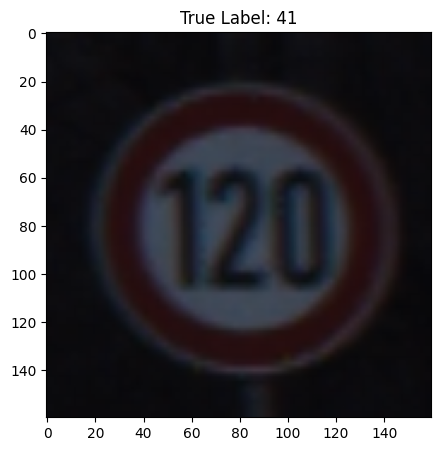

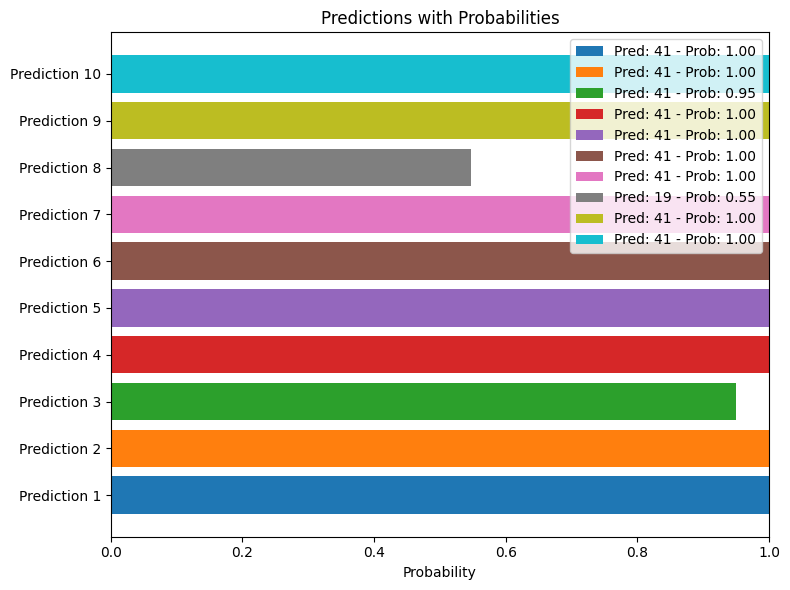

Predictive Uncertainty (Variance): 0.0029


In [32]:
# Function to get predictions by sampling from the posterior
def sample_posterior(model, image, num_samples, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # List to store predictions

    with torch.no_grad():
        # Sample predictions for the provided image
        for _ in range(num_samples):
            output = model(image)  # Forward pass
            probs = torch.nn.functional.softmax(output, dim=-1)  # Get probabilities
            predictions.append(probs[0].cpu())  # Store probabilities for the first image

    predictions_tensor = torch.stack(predictions)  # Stack predictions into a tensor

    # Quantify uncertainty using variance
    predictive_uncertainty = predictive_variance(predictions_tensor.numpy())

    return predictions_tensor, predictive_uncertainty

# Function to visualize predictions for a single image
def visualize_single_image_predictions(image, label, predictions):
    image = denormalize(image)  # Denormalize before displaying
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Assuming images are in [C, H, W] format
    plt.title(f'True Label: {label}')

    # Display predictions with probabilities
    plt.figure(figsize=(8, 6))
    for i, probs in enumerate(predictions):
        predicted_class = torch.argmax(probs).item()
        probability = probs[predicted_class].item()
        plt.barh(i, probability, label=f'Pred: {predicted_class} - Prob: {probability:.2f}')

    plt.xlabel('Probability')
    plt.yticks(range(len(predictions)), [f'Prediction {j+1}' for j in range(len(predictions))])
    plt.title('Predictions with Probabilities')
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Set the number of samples
num_samples = 10

# Get predictions for a single image from the validation set
with torch.no_grad():
    for images, labels in val_dl:
        images, labels = images.to(device), labels.to(device)

        # Sample predictions for one image by adding a batch dimension
        predictions, predictive_uncertainty = sample_posterior(bnn_model, images[0].unsqueeze(0), num_samples, device)

        # Visualize the predictions for the single image
        visualize_single_image_predictions(images[0], labels[0], predictions)

        # Print the predictive uncertainty
        print(f"Predictive Uncertainty (Variance): {predictive_uncertainty:.4f}")
        break  # Show only one image

### Test dropping KL in loss

Try dropping KL in loss

In [33]:
# Training function for Bayesian CNN
# Says not enough memory if trying to get accuracy using MC during train
def train_bnn_no_KL(model, train_loader, criterion, optimizer, device, args):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    total_samples = 0

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        optimizer.zero_grad()  # Clear the gradients
        output = model(x_train)  # Forward pass

        ce_loss = criterion(output, y_train)  # Cross-entropy loss
        loss = ce_loss  # Total loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        total_loss += loss.item()

    # Step the scheduler at the end of each epoch
    scheduler.step()

    average_loss = total_loss / len(train_loader)
    return average_loss

# Validation function for Bayesian CNN
def evaluate_bnn_no_KL(model, val_loader, criterion, device, args):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_y_true = []
    variance_list = []  # List to accumulate variances for each batch

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Collect raw outputs (logits) for each Monte Carlo run
            outputs_mc = []
            for mc_run in range(args.num_monte_carlo):
                raw_output = model(x_val)  # Raw output (logits) from model
                outputs_mc.append(raw_output)

            # Stack raw outputs along the first dimension (num_monte_carlo, batch_size, num_classes)
            outputs_mc_tensor = torch.stack(outputs_mc)  # Shape: (num_monte_carlo, batch_size, num_classes)

            # Calculate softmax for each Monte Carlo run
            probs_mc = [F.softmax(raw_output, dim=-1) for raw_output in outputs_mc]
            probs_mc_tensor = torch.stack(probs_mc)  # Shape: (num_monte_carlo, batch_size, num_classes)

            # Calculate the mean of probabilities for loss and accuracy
            probs_mean = probs_mc_tensor.mean(dim=0)  # Shape: (batch_size, num_classes)

            # Compute negative log-likelihood loss using the mean probabilities
            # We use NLLLoss, which expects log probabilities, so we take the log of the mean probabilities
            log_probs_mean = torch.log(probs_mean)
            ce_loss = F.nll_loss(log_probs_mean, y_val)
            total_loss += ce_loss.item()
            total_samples += y_val.size(0)

            # Calculate predicted class by taking the argmax of the mean probabilities
            y_pred = torch.argmax(probs_mean, dim=-1)
            all_preds.extend(y_pred.cpu().numpy())  # Collect predictions for the entire validation set
            all_y_true.extend(y_val.cpu().numpy())

            # Calculate predictive variance for the batch (variance of probabilities)
            pred_variance = probs_mc_tensor.var(dim=0)  # Variance across MC samples
            variance_list.append(pred_variance.mean().item())  # Average variance for this batch

    # Calculate overall accuracy on validation
    accuracy = (np.array(all_preds) == np.array(all_y_true)).mean()
    average_loss = total_loss / len(val_loader)
    avg_pred_variance = np.mean(variance_list)  # Average variance across batches

    return average_loss, accuracy, avg_pred_variance

In [34]:
def load_or_train_bnn_model_no_KL(model_path, epochs, model, loss_func, opt, train_dl, val_dl, device):
    try:
        # Load the pre-trained BNN model
        model.load_state_dict(torch.load(model_path, map_location=device))
        # Move the model to the specified device
        model.to(device)
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        # Train the model if no saved model exists
        print(f"Model not found at {model_path}, starting training.")

        # Move the model to the specified device before training
        model.to(device)

        # Training loop
        for epoch in range(epochs):
            train_loss = train_bnn_no_KL(model, train_dl, loss_func, opt, device, args)
            val_loss, val_accuracy, _ = evaluate_bnn_no_KL(model, val_dl, loss_func, device, args)

            print(f"Epoch [{epoch + 1}/{epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Validation Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {val_accuracy:.4f}")

        # Save the trained model
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

In [35]:
bnn_model_no_KL = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

In [36]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # Don't intialize mu/sigma from a trained model
        "moped_delta": 0.5,
}
dnn_to_bnn(bnn_model_no_KL, const_bnn_prior_parameters)
summary(bnn_model_no_KL)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2dReparameterization: 1-1          896
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Conv2dReparameterization: 1-4          9,280
├─BatchNorm2d: 1-5                       64
├─ReLU: 1-6                              --
├─Conv2dReparameterization: 1-7          36,992
├─BatchNorm2d: 1-8                       128
├─ReLU: 1-9                              --
├─Conv2dReparameterization: 1-10         147,712
├─BatchNorm2d: 1-11                      256
├─ReLU: 1-12                             --
├─Conv2dReparameterization: 1-13         590,336
├─BatchNorm2d: 1-14                      512
├─ReLU: 1-15                             --
├─AdaptiveAvgPool2d: 1-16                --
├─Lambda: 1-17                           --
├─LinearReparameterization: 1-18         65,792
├─ReLU: 1-19                             --
├─LinearReparameterization: 1-20         11,09

In [97]:
class Args:
    learning_rate = 0.01
    num_epochs = 25
    num_monte_carlo = 100

args = Args()

In [38]:
path_model_bnn_no_KL ='/content/gdrive/MyDrive/German-traffic-signs/bnn_model_no_KL.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bnn_model_no_KL.parameters(), lr=args.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_or_train_bnn_model_no_KL(path_model_bnn_no_KL, args.num_epochs, bnn_model_no_KL, criterion, optimizer, train_dl, val_dl, device)

<ipython-input-34-ee76e70cdcf0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model not found at /content/gdrive/MyDrive/German-traffic-signs/bnn_model_no_KL.pth, starting training.
Epoch [1/25], Train Loss: 2.5868, Validation Loss: 1.9114, Validation Accuracy: 0.3865
Epoch [2/25], Train Loss: 1.4739, Validation Loss: 1.1827, Validation Accuracy: 0.6249
Epoch [3/25], Train Loss: 0.6415, Validation Loss: 0.4774, Validation Accuracy: 0.8505
Epoch [4/25], Train Loss: 0.2423, Validation Loss: 0.3110, Validation Accuracy: 0.9175
Epoch [5/25], Train Loss: 0.1272, Validation Loss: 0.1905, Validation Accuracy: 0.9498
Epoch [6/25], Train Loss: 0.0724, Validation Loss: 0.1906, Validation Accuracy: 0.9424
Epoch [7/25], Train Loss: 0.0538, Validation Loss: 0.2350, Validation Accuracy: 0.9405
Epoch [8/25], Train Loss: 0.0513, Validation Loss: 0.3470, Validation Accuracy: 0.8857
Epoch [9/25], Train Loss: 0.0413, Validation Loss: 0.0927, Validation Accuracy: 0.9760
Epoch [10/25], Train Loss: 0.0404, Validation Loss: 0.1197, Validation Accuracy: 0.9640
Epoch [11/25], Train Loss

# Out of distribution data

We in this section want to compare robustness of our CNN and bayesian our CNN against adversiaral attacks and/or out of distribtuion (OOD) data.

Here we want to check what happens if we give our model for example a sign it hasn't seen before.

We want in the ideal case our CNN model to give same prob for each class, since it should reflect the uncertainty it has.

For the bayesian CNN we also want it for each sample of the posterior to give many different classes since it should be unsure about what this sign is.

We load a no-u-turn image (not present in the labels we had).

### On a U-turn sign and a dog

In [56]:
image_path_no_u_turn = '/content/gdrive/MyDrive/German-traffic-signs/no-u-turn.jpg'
image_no_u_turn = Image.open(image_path_no_u_turn)


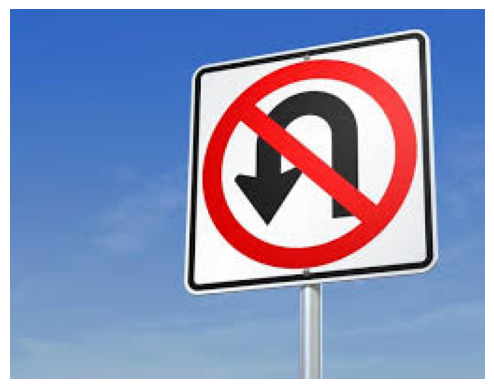

In [57]:
# Visualize the original image before applying transformations
plt.imshow(image_no_u_turn)
plt.axis('off')
plt.show()

In [58]:
# Apply the defined transformations
no_u_turn = transform(image_no_u_turn)

# Add a batch dimension (1, C, H, W) since the model expects a batch
no_u_turn = no_u_turn.unsqueeze(0)  # shape will be (1, 3, 160, 160)

print(no_u_turn.shape)

torch.Size([1, 3, 160, 160])


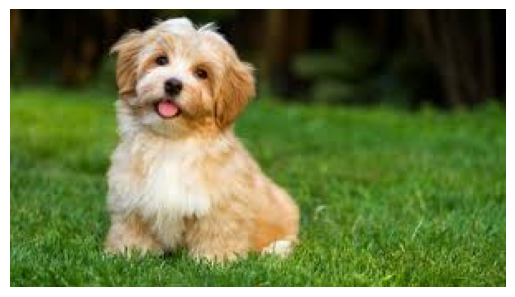

In [42]:
image_path_dog = '/content/gdrive/MyDrive/German-traffic-signs/dog.jpg'
image_dog = Image.open(image_path_dog)

# Visualize the original image before applying transformations
plt.imshow(image_dog)
plt.axis('off')
plt.show()


In [43]:
# Apply the defined transformations
dog = transform(image_dog)

# Add a batch dimension (1, C, H, W) since the model expects a batch
dog = dog.unsqueeze(0)  # shape will be (1, 3, 160, 160)

print(dog.shape)

torch.Size([1, 3, 160, 160])


In [44]:
dog = dog.to(device)

#### CNN model

For our CNN model on no-u-turn

In [59]:
no_u_turn = no_u_turn.to(device)
model.to(device)

model.eval()  # Set the model to evaluation mode

# Perform inference (no gradient calculation needed)
with torch.no_grad():
    output = model(no_u_turn)

# Apply softmax to get probabilities
probabilities = F.softmax(output, dim=1)

# Get the top 5 probabilities and their corresponding class indices
top5_probabilities, top5_classes = torch.topk(probabilities, 5)

# Move the results back to the CPU if using GPU
top5_probabilities = top5_probabilities.cpu().numpy().flatten()
top5_classes = top5_classes.cpu().numpy().flatten()

# Print the top 5 classes with their probabilities
print("Top 5 predicted classes and probabilities:")
for i in range(5):
    print(f"Class: {top5_classes[i]}, Probability: {top5_probabilities[i]:.4f}")


Top 5 predicted classes and probabilities:
Class: 5, Probability: 0.8436
Class: 10, Probability: 0.1018
Class: 4, Probability: 0.0261
Class: 13, Probability: 0.0242
Class: 24, Probability: 0.0032


Fairly confident in class 5.

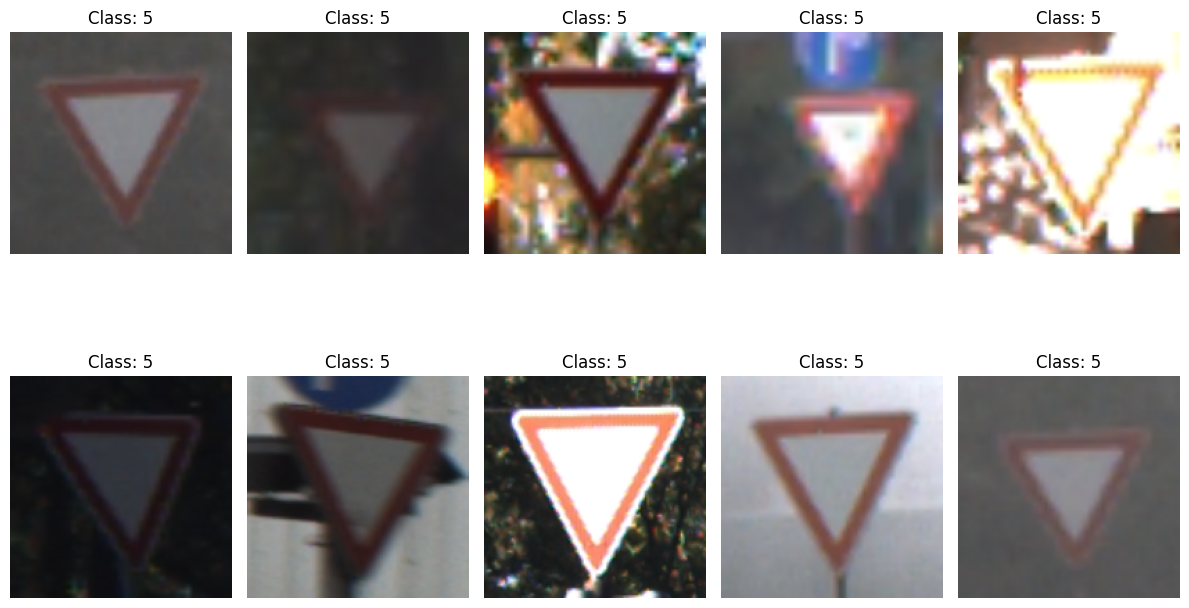

In [62]:
# Variables to store images and labels for class 5
class_5_images = []
class_5_label = 5  # The target class

# Iterate over the training data to collect 10 images from class 5
for images, labels in train_dl:
    for i in range(len(images)):
        if labels[i].item() == class_5_label:
            class_5_images.append(images[i])
        # Stop once we have collected 10 images
        if len(class_5_images) == 10:
            break
    if len(class_5_images) == 10:
        break

# Plot the 10 images from class 5
plt.figure(figsize=(12, 8))
num_images_per_row = 5  # Maximum images per row

for i, img in enumerate(class_5_images):
    plt.subplot(2, num_images_per_row, i + 1)
    imshow(img)
    plt.title(f'Class: {class_5_label}')

plt.tight_layout()
plt.show()

But class 5 is a yield sign not a no-u-turn sign.

On a dog

In [52]:
model.to(device)

model.eval()  # Set the model to evaluation mode

# Perform inference (no gradient calculation needed)
with torch.no_grad():
    output = model(dog)

# Apply softmax to get probabilities
probabilities = F.softmax(output, dim=1)

# Get the top 5 probabilities and their corresponding class indices
top5_probabilities, top5_classes = torch.topk(probabilities, 5)

# Move the results back to the CPU if using GPU
top5_probabilities = top5_probabilities.cpu().numpy().flatten()
top5_classes = top5_classes.cpu().numpy().flatten()

# Print the top 5 classes with their probabilities
print("Top 5 predicted classes and probabilities:")
for i in range(5):
    print(f"Class: {top5_classes[i]}, Probability: {top5_probabilities[i]:.4f}")

Top 5 predicted classes and probabilities:
Class: 5, Probability: 0.4817
Class: 13, Probability: 0.2663
Class: 10, Probability: 0.1242
Class: 4, Probability: 0.0462
Class: 19, Probability: 0.0276


Fairly confident in class 5.

#### MC Dropout model

In [63]:
def visualize_mc_dropout(model, image, num_samples=10, top_k=3, label=None):
    model.train()  # Set to train mode to keep dropout active
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image = image.to(device)  # Move image to device

    with torch.no_grad():
        all_probs = []
        all_classes = []
        for _ in range(num_samples):
            output = model(image)  # Forward pass with dropout active
            prob = F.softmax(output, dim=1)  # Apply softmax for probabilities
            top_probs, top_classes = torch.topk(prob, top_k, dim=1)  # Get top-k predictions
            all_probs.append(top_probs.squeeze())
            all_classes.append(top_classes.squeeze())

        # Display the image with predictions from multiple MC dropout samples
        single_image = denormalize(image.squeeze())  # Denormalize image for display
        plt.figure(figsize=(15, 15))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(single_image.permute(1, 2, 0).cpu().numpy())  # Convert [C, H, W] to [H, W, C]
            plt.title("Top Predictions:\n" +
                      "\n".join([f"Class {int(cls)}: {float(prob):.2f}"
                                 for cls, prob in zip(all_classes[i], all_probs[i])]))
            plt.axis("off")
        if label is not None:
            plt.suptitle(f"MC Dropout Predictions - True Class: {label.item()}")
        else:
            plt.suptitle("MC Dropout Predictions")
        plt.show()

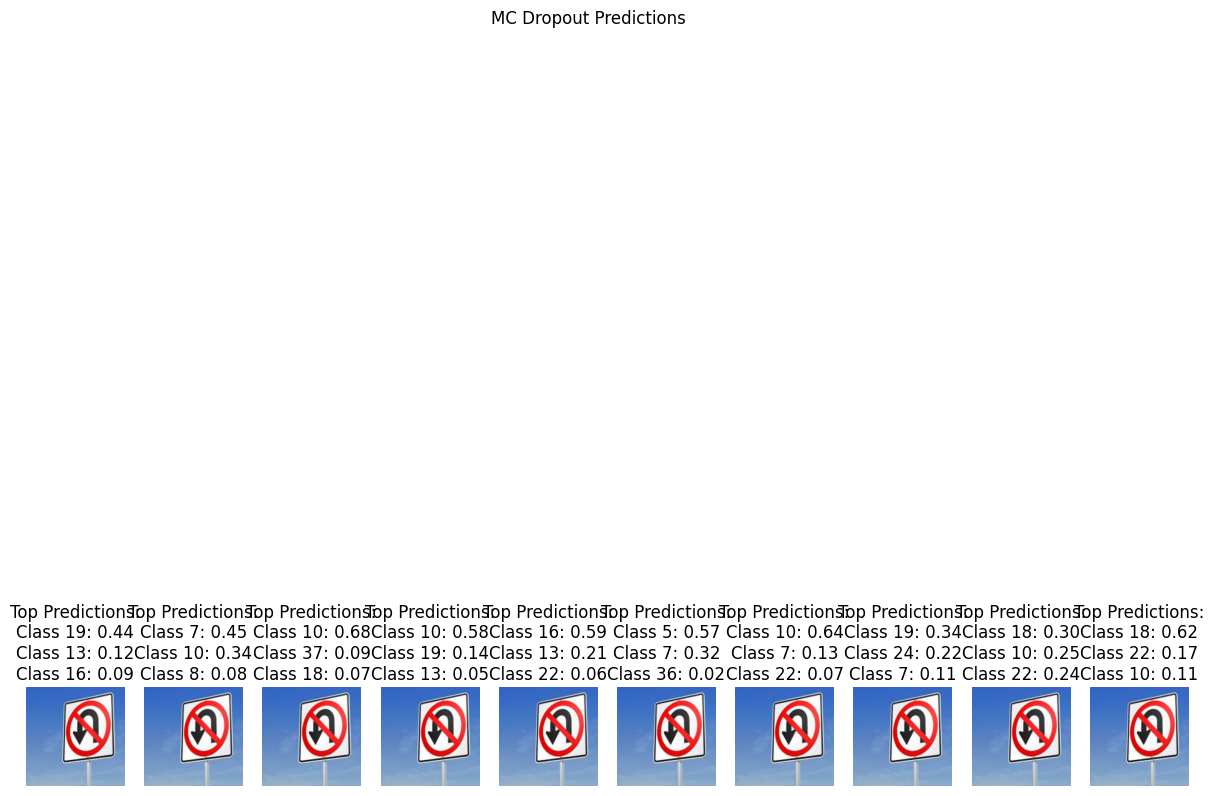

In [64]:
visualize_mc_dropout(model, no_u_turn, num_samples=10, top_k=3)

In [65]:
def evaluate_mc_dropout_single_image(model, image, num_samples=10000):
    model.train()  # Ensure dropout is active
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    image = image.to(device)

    with torch.no_grad():
        # Collect predictions over multiple dropout samples, applying softmax to get probabilities
        preds_list = [torch.softmax(model(image), dim=1) for _ in range(num_samples)]
        preds_stack = torch.stack(preds_list)  # Shape: (num_samples, 1, num_classes)

        # Compute variance across the samples
        preds_var = preds_stack.var(dim=0).squeeze(0)    # Shape: (num_classes,)

        # Average variance across classes for the single image
        avg_variance = preds_var.mean().item()

    return avg_variance

In [66]:
avg_variance = evaluate_mc_dropout_single_image(model, no_u_turn)
print(f"Avg Variance: {avg_variance}")

Avg Variance: 0.004954377189278603


Compare to an image in the data.

In [67]:
def evaluate_mc_dropout_random_image(model, data_loader, num_samples=100):
    model.train()  # Ensure dropout is active
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Randomly select one batch from the dataloader
    random_batch = random.choice(list(data_loader))
    xb, yb = random_batch[0].to(device), random_batch[1].to(device)

    # Select a single image and its label
    single_image, single_label = xb[0].unsqueeze(0), yb[0].unsqueeze(0)

    with torch.no_grad():
        # Collect predictions over multiple dropout samples for the single image
        preds_list = [torch.softmax(model(single_image), dim=1) for _ in range(num_samples)]
        preds_stack = torch.stack(preds_list)  # Shape: (num_samples, 1, num_classes)

        # Compute variance across the samples (for each class probability)
        preds_var = preds_stack.var(dim=0)  # Shape: (1, num_classes)
        avg_variance = preds_var.mean().item()  # Average variance across classes for the single image

    return avg_variance


In [68]:
avg_variance = evaluate_mc_dropout_random_image(model, val_dl)
print(f"Avg Variance: {avg_variance}")

Avg Variance: 0.0023298896849155426


On a dog

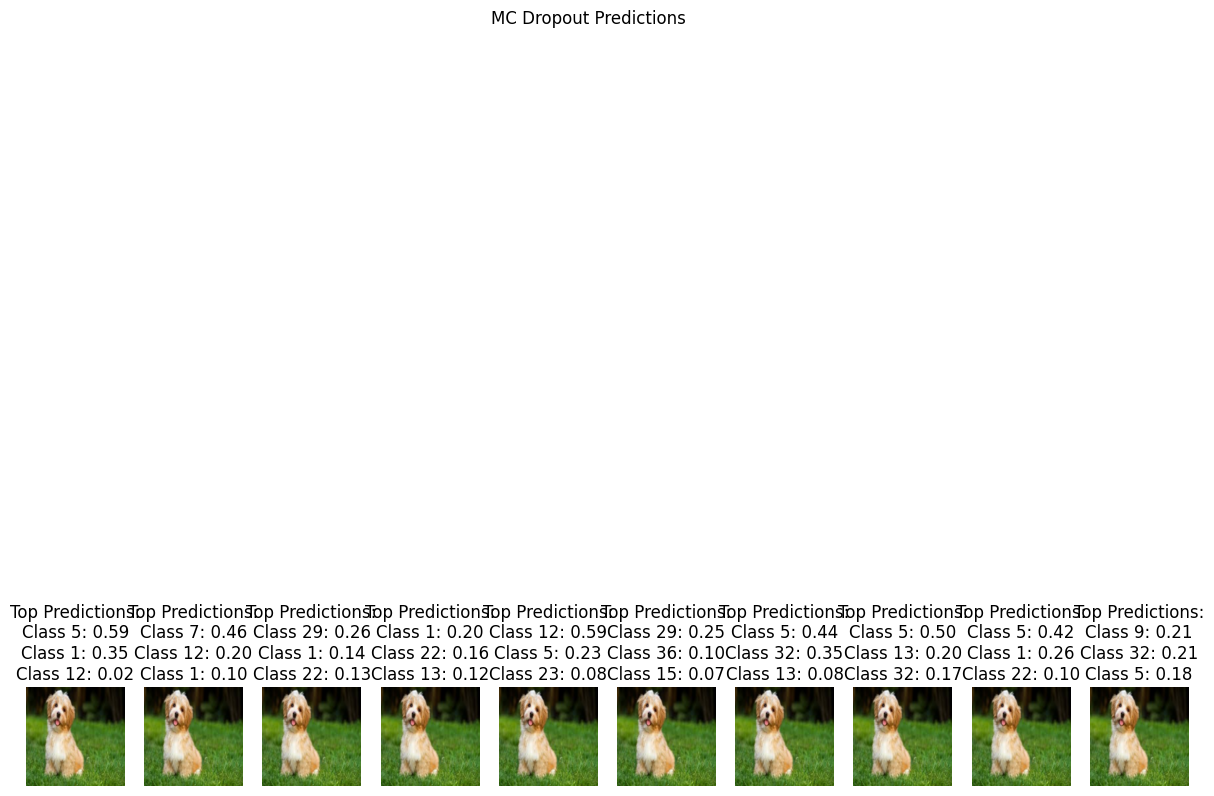

In [69]:
visualize_mc_dropout(model, dog, num_samples=10, top_k=3)

In [70]:
avg_variance = evaluate_mc_dropout_single_image(model, dog, num_samples = 1000)
print(f"Avg Variance: {avg_variance}")

Avg Variance: 0.004824353847652674


##### Finding low and high variance images

In [71]:
def calculate_variance(model, image, num_samples=100):
    model.train()  # Ensure dropout is active
    with torch.no_grad():
        preds_list = [torch.softmax(model(image), dim=1) for _ in range(num_samples)]
        preds_stack = torch.stack(preds_list)  # Shape: (num_samples, 1, num_classes)
        preds_var = preds_stack.var(dim=0).squeeze(0)  # Shape: (num_classes,)
        avg_variance = preds_var.mean().item()
    return avg_variance

# Function to find and visualize images with highest and lowest variance
def visualize_mc_dropout_from_dataloader(model, dataloader, num_samples=100, top_k=3):
    model.train()  # Ensure dropout is active
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    highest_var_image, lowest_var_image = None, None
    highest_var, lowest_var = -float('inf'), float('inf')

    # Iterate through all images
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        for i in range(images.size(0)):  # Loop over each image in the batch
            image = images[i].unsqueeze(0)  # Add batch dimension for single image
            variance = calculate_variance(model, image, num_samples=num_samples)

            # Update highest and lowest variance images
            if variance > highest_var:
                highest_var = variance
                highest_var_image = (image, labels[i])
            if variance < lowest_var:
                lowest_var = variance
                lowest_var_image = (image, labels[i])

    # Visualize the highest and lowest variance images
    if highest_var_image is not None and lowest_var_image is not None:
        print(f"Highest Variance: {highest_var}, Lowest Variance: {lowest_var}")
        visualize_mc_dropout(model, highest_var_image[0], num_samples=5, top_k=top_k, label=highest_var_image[1])
        visualize_mc_dropout(model, lowest_var_image[0], num_samples=5, top_k=top_k, label=lowest_var_image[1])
    else:
        print("No images found with variance.")

Highest Variance: 0.011343845166265965, Lowest Variance: 0.00041437504114583135


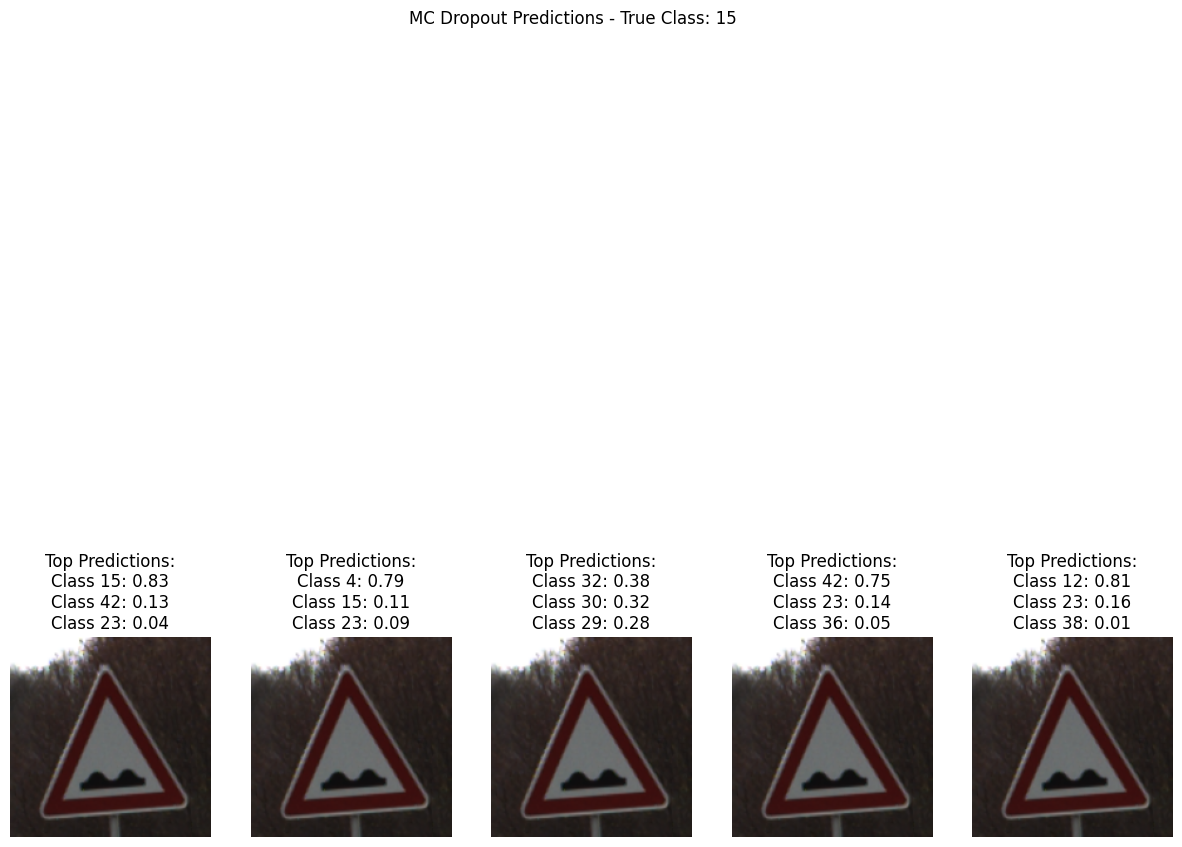

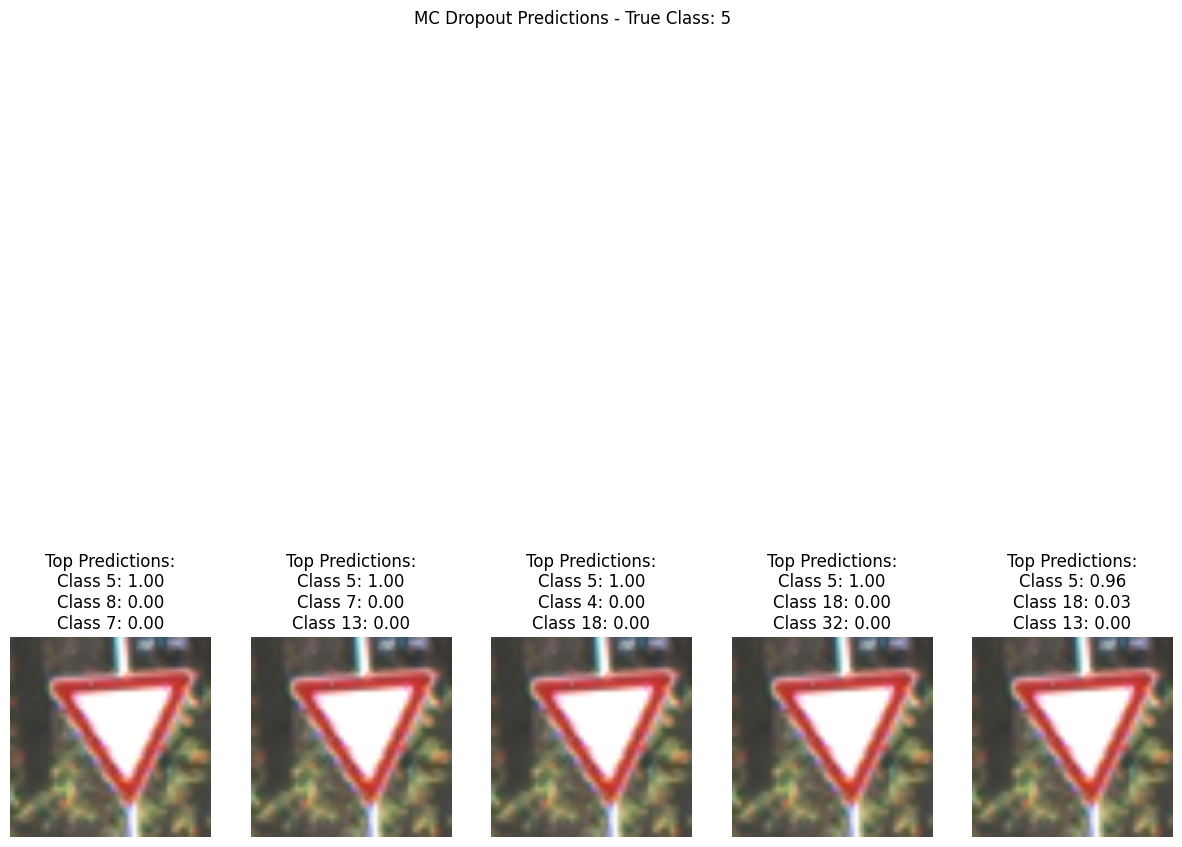

In [72]:
visualize_mc_dropout_from_dataloader(model, val_dl)

#### Bayesian CNN model

For our bayesian CNN model

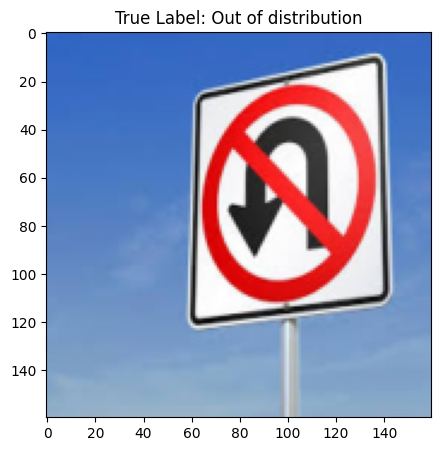

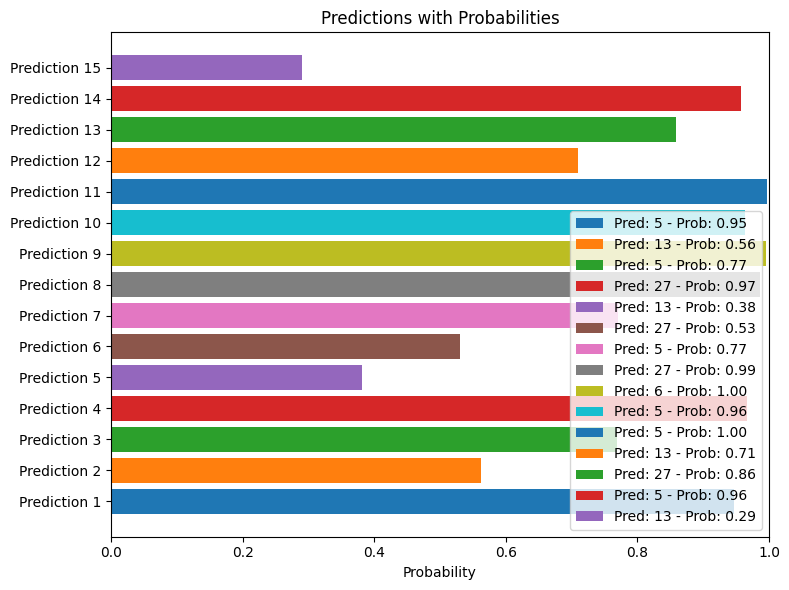

In [73]:
num_samples = 15  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
predictions, predictive_uncertainty = sample_posterior(bnn_model, no_u_turn.to(device), num_samples, device)

# Visualize the predictions for the no_u_turn image
visualize_single_image_predictions(no_u_turn.squeeze(0), "Out of distribution", predictions)

In [74]:
num_samples = 1000  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
_, predictive_uncertainty = sample_posterior(bnn_model, no_u_turn.to(device), num_samples, device)
print(f"Predictive Uncertainty (Variance): {predictive_uncertainty:.4f}")

Predictive Uncertainty (Variance): 0.0099


Compare to random image

In [75]:
# Function to get predictions by sampling from the posterior for a random image from the dataloader
def sample_posterior_random_image(model, dataloader, num_samples, device):
    model.train()  # Set the model to train mode
    predictions = []  # List to store predictions

    # Select a random image from the dataloader
    random_batch = random.choice(list(dataloader))  # Get a random batch from the dataloader
    image, _ = random_batch  # Assuming the dataloader returns (image, label) tuples
    image = image[0].unsqueeze(0).to(device)  # Get the first image in the batch and move to device

    with torch.no_grad():
        # Sample predictions for the selected random image
        for _ in range(num_samples):
            output = model(image)  # Forward pass
            probs = torch.nn.functional.softmax(output, dim=-1)  # Get probabilities
            predictions.append(probs[0].cpu())  # Store probabilities

    predictions_tensor = torch.stack(predictions)  # Stack predictions into a tensor

    # Quantify uncertainty using variance
    predictive_uncertainty = predictive_variance(predictions_tensor.numpy())

    return predictions_tensor, predictive_uncertainty

In [76]:
num_samples = 1000  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
_, predictive_uncertainty = sample_posterior_random_image(bnn_model, val_dl, num_samples, device)
print(f"Predictive Uncertainty (Variance): {predictive_uncertainty:.4f}")

Predictive Uncertainty (Variance): 0.0036


On a dog

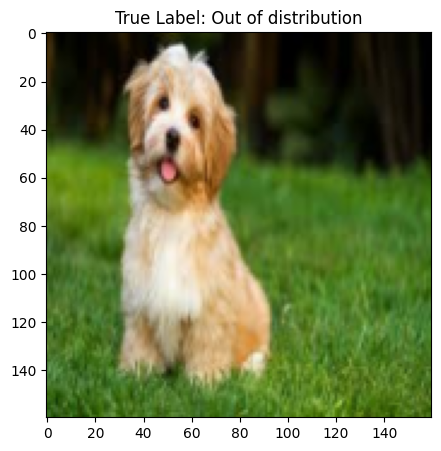

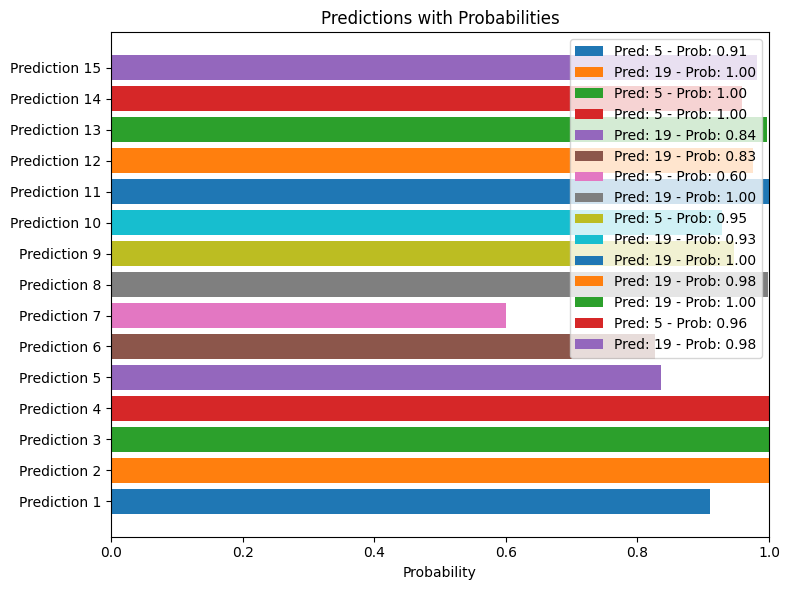

In [77]:
num_samples = 15  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
predictions, predictive_uncertainty = sample_posterior(bnn_model, dog, num_samples, device)

# Visualize the predictions for the no_u_turn image
visualize_single_image_predictions(dog.squeeze(0), "Out of distribution", predictions)

In [78]:
num_samples = 1000  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
_, predictive_uncertainty = sample_posterior(bnn_model, dog, num_samples, device)
print(f"Predictive Uncertainty (Variance): {predictive_uncertainty:.4f}")

Predictive Uncertainty (Variance): 0.0088


##### Finding low and high variance images

In [79]:
# Function to calculate variance for Bayesian CNN
def calculate_variance_bayesian(model, image, num_samples=100, device='cpu'):
    predictions_tensor, predictive_uncertainty = sample_posterior(model, image.to(device), num_samples, device)
    avg_variance = predictive_uncertainty.mean()  # Average variance across classes
    return avg_variance

# Function to find and visualize images with highest and lowest variance in Bayesian CNN
def visualize_bayesian_from_dataloader(model, dataloader, num_samples=100, top_k=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    highest_var_image, lowest_var_image = None, None
    highest_var, lowest_var = -float('inf'), float('inf')

    # Iterate through a batch of images
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        for i in range(images.size(0)):  # Loop over each image in the batch
            image = images[i].unsqueeze(0)  # Add batch dimension for single image
            variance = calculate_variance_bayesian(model, image, num_samples=num_samples, device=device)

            # Update highest and lowest variance images
            if variance > highest_var:
                highest_var = variance
                highest_var_image = (image, labels[i])
            if variance < lowest_var:
                lowest_var = variance
                lowest_var_image = (image, labels[i])

    # Visualize the highest and lowest variance images
    if highest_var_image is not None and lowest_var_image is not None:
        print(f"Highest Variance: {highest_var}, Lowest Variance: {lowest_var}")
        visualize_mc_dropout(model, highest_var_image[0], num_samples=5, top_k=top_k, label=highest_var_image[1])
        visualize_mc_dropout(model, lowest_var_image[0], num_samples=5, top_k=top_k, label=lowest_var_image[1])
    else:
        print("No images found with variance.")

Highest Variance: 0.016418524086475372, Lowest Variance: 1.268403264835368e-22


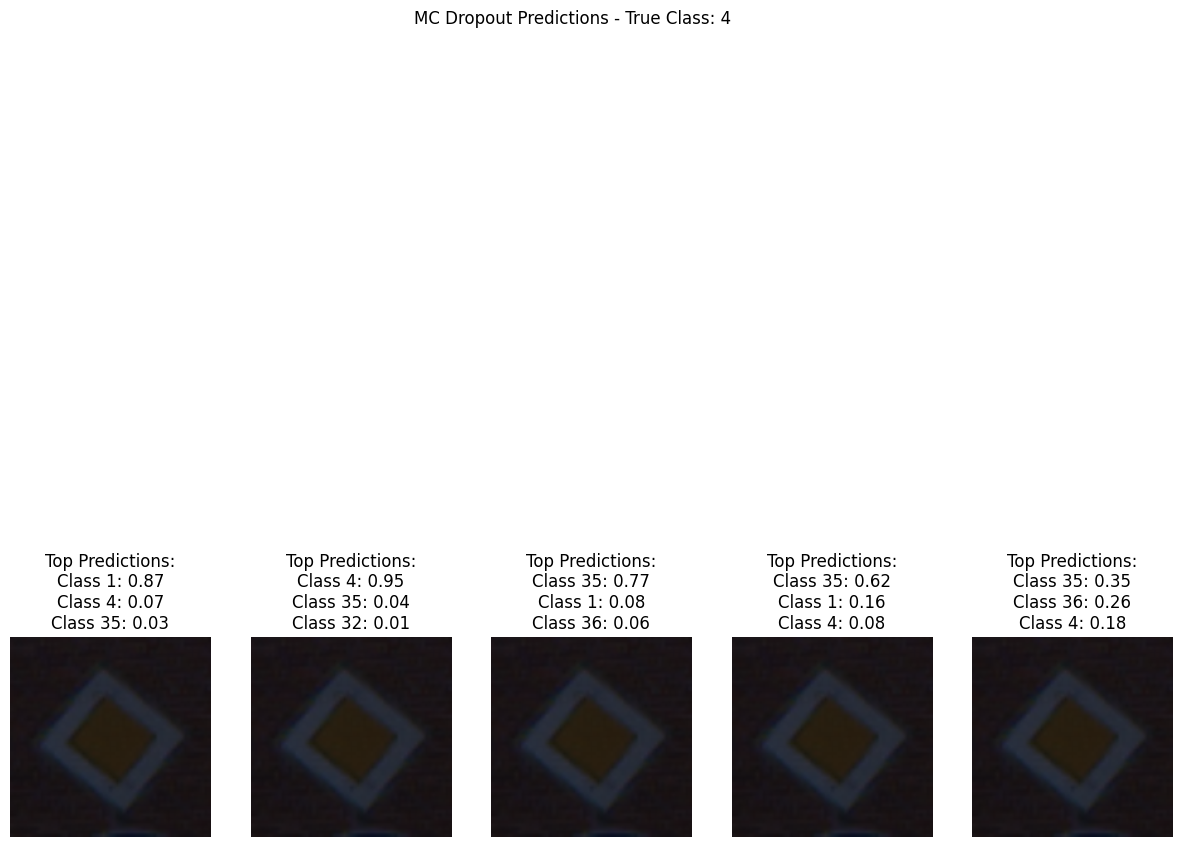

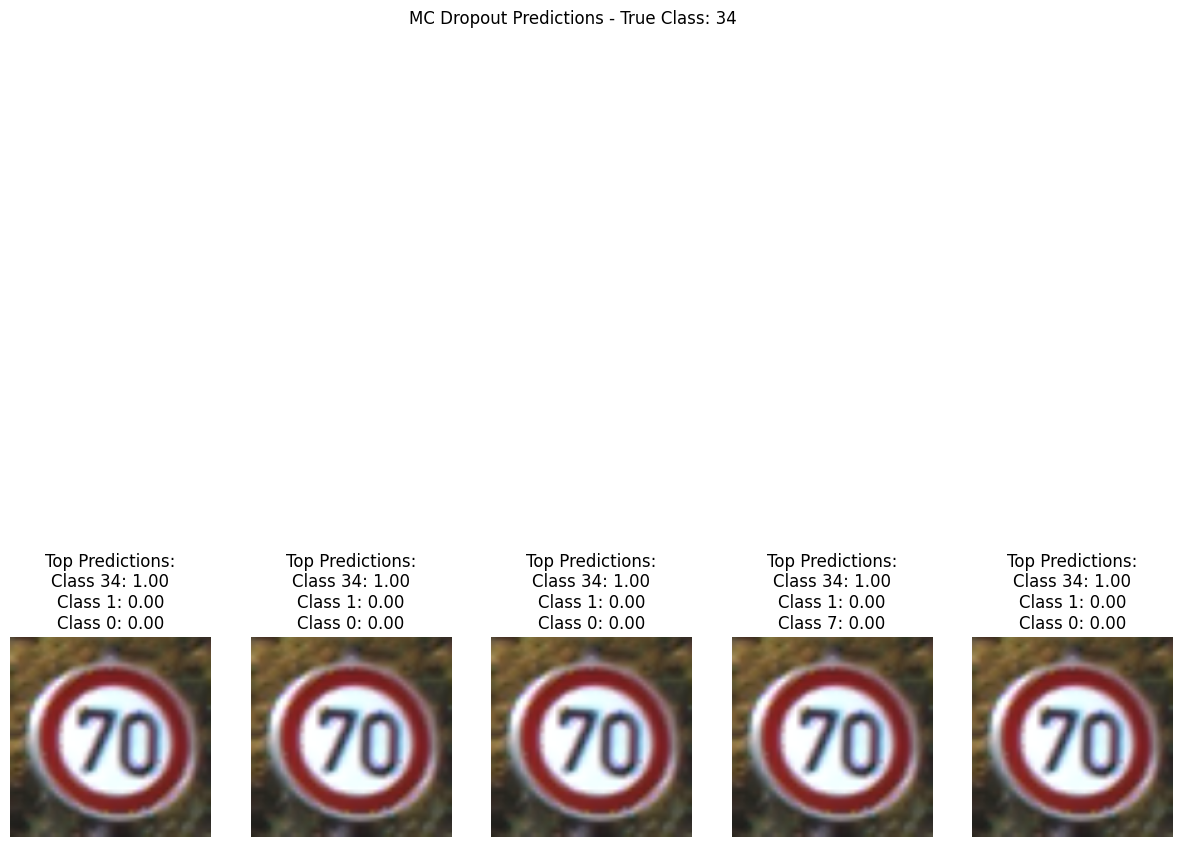

In [80]:
visualize_bayesian_from_dataloader(bnn_model, val_dl)

#### Bayesian CNN model no KL term in loss

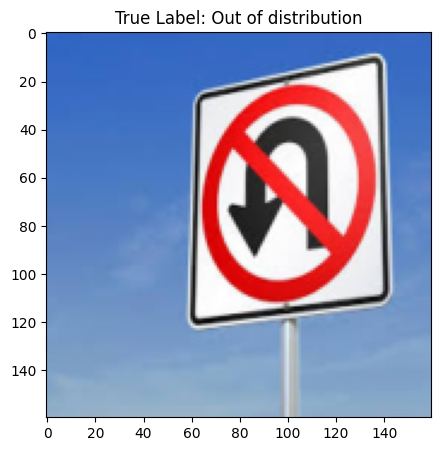

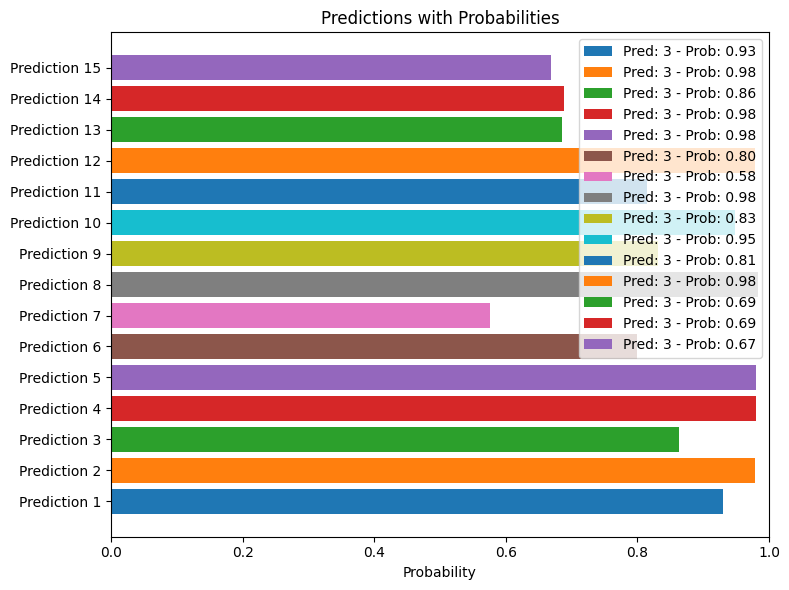

In [81]:
num_samples = 15  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
predictions, predictive_uncertainty = sample_posterior(bnn_model_no_KL, no_u_turn.to(device), num_samples, device)

# Visualize the predictions for the no_u_turn image
visualize_single_image_predictions(no_u_turn.squeeze(0), "Out of distribution", predictions)

In [82]:
num_samples = 1000  # Number of samples for the posterior
# Sample predictions for the no_u_turn image
_, predictive_uncertainty = sample_posterior_random_image(bnn_model_no_KL, val_dl, num_samples, device)
print(f"Predictive Uncertainty (Variance): {predictive_uncertainty:.4f}")

Predictive Uncertainty (Variance): 0.0009


##### Finding low and high variance images

Highest Variance: 0.012487664818763733, Lowest Variance: 0.0


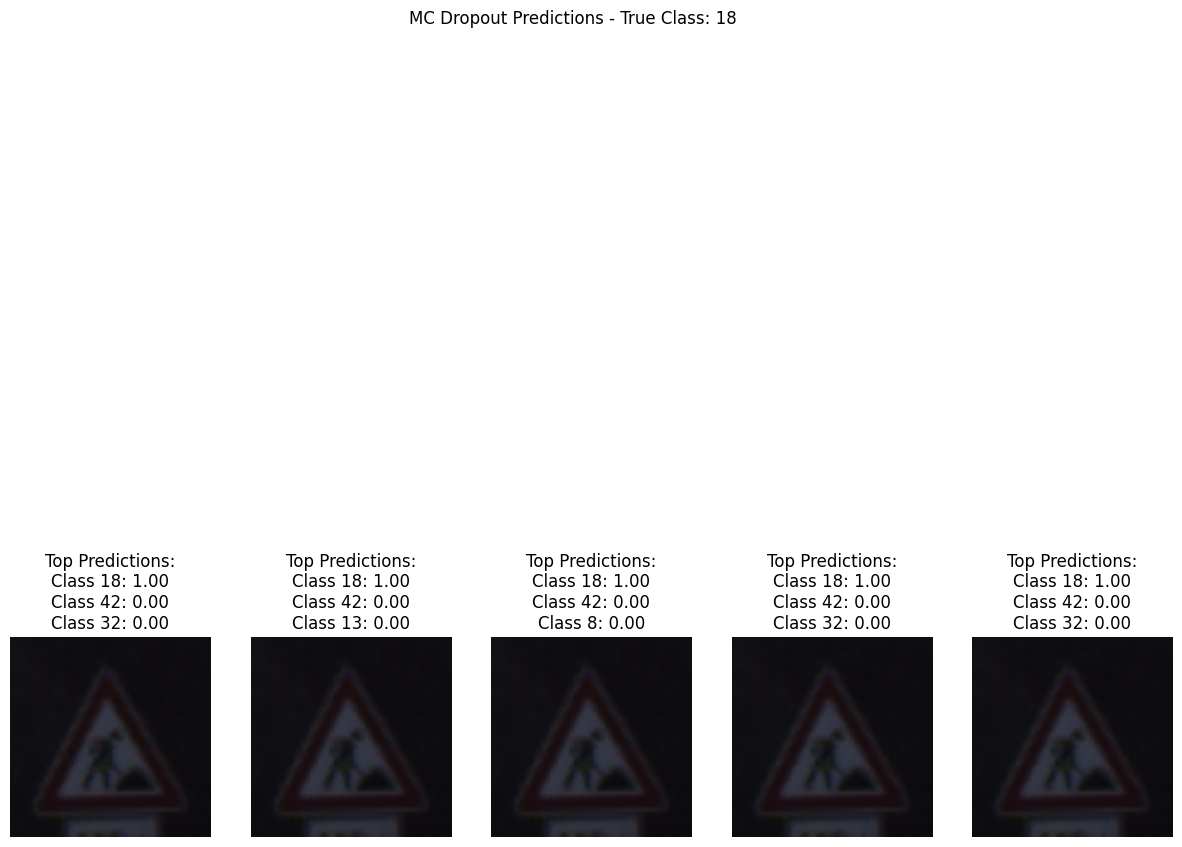

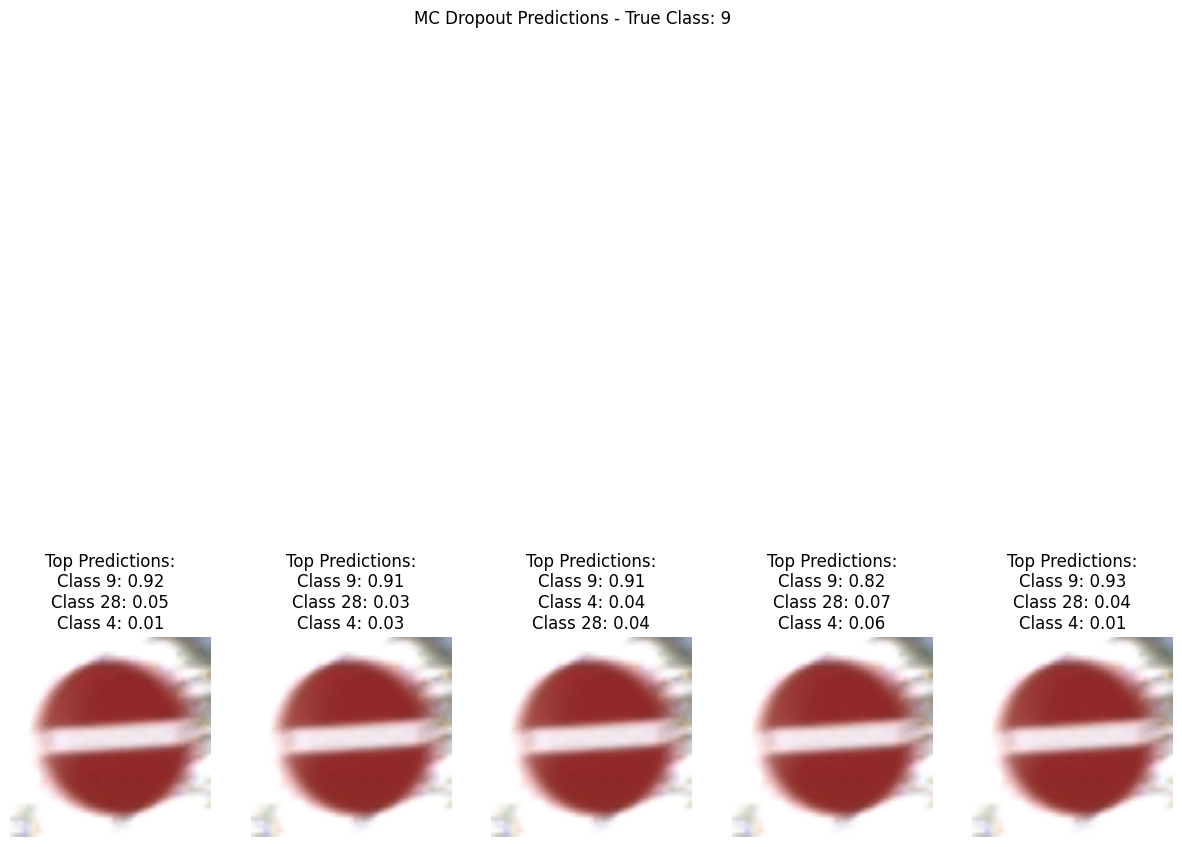

In [83]:
visualize_bayesian_from_dataloader(bnn_model_no_KL, val_dl)

# Trying on test data

## Our CNN model

In [53]:
def evaluate(model, test_dl, loss_func):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loss_total = 0.0
    test_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for inference
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            # Compute loss
            loss, _ = loss_batch(model, loss_func, xb, yb)
            test_loss_total += loss

            # Compute accuracy
            preds = model(xb).argmax(dim=1)
            test_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

    # Calculate average test loss and accuracy
    test_loss_avg = test_loss_total / len(test_dl)
    test_acc = test_correct / total_samples

    print(f"Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_acc:.4f}")

    return test_loss_avg, test_acc

### Without MC dropout

In [55]:
test_loss_eval, test_accuracy_eval = evaluate(model, test_dl, loss_func)

Test Loss: 0.0703, Test Accuracy: 0.9842


### With MC dropout

In [84]:
val_avg_loss, val_accuracy, val_avg_variance = evaluate_mc_dropout(model, val_dl, num_samples = 100)

In [85]:
print(f"Evaluation Results:\n"
      f"-------------------\n"
      f"Average Loss: {val_avg_loss:.4f}\n"
      f"Accuracy: {val_accuracy:.4f}\n"
      f"Average Variance: {val_avg_variance:.4f}")

Evaluation Results:
-------------------
Average Loss: 0.0621
Accuracy: 0.9862
Average Variance: 0.0024


In [86]:
test_avg_loss, test_accuracy, test_avg_variance = evaluate_mc_dropout(model, test_dl, num_samples = 100)

In [87]:
print(f"Evaluation Results:\n"
      f"-------------------\n"
      f"Average Loss: {test_avg_loss:.4f}\n"
      f"Accuracy: {test_accuracy:.4f}\n"
      f"Average Variance: {test_avg_variance:.4f}")

Evaluation Results:
-------------------
Average Loss: 0.0748
Accuracy: 0.9835
Average Variance: 0.0024


## Our Bayesian CNN with KL

In [88]:
class Args:
    num_monte_carlo = 100

args = Args()

criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
test_loss_w_kl, test_accuracy_w_kl, test_variance_w_kl = evaluate_bnn(bnn_model, test_dl, criterion, device, args)

In [90]:
print(f"Test Loss (trained with KL): {test_loss_w_kl:.4f}")
print(f"Test Accuracy with KL: {test_accuracy_w_kl:.4f}")
print(f"Test Variance with KL: {test_variance_w_kl.mean():.4f}") # Calculate the mean of the variance array before formatting

Test Loss (trained with KL): 0.5824
Test Accuracy with KL: 0.8540
Test Variance with KL: 0.0056


## Our Bayesian CNN without KL

In [105]:
class Args:
    num_monte_carlo = 100

args = Args()

criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [106]:
val_loss_no_kl, val_accuracy_no_kl, val_variance_no_kl = evaluate_bnn_no_KL(bnn_model_no_KL, val_dl, criterion, device, args)

In [107]:
print(f"Validation Loss (trained without KL): {val_loss_no_kl:.4f}")
print(f"Validation Accuracy without KL: {val_accuracy_no_kl:.4f}")
print(f"Validation Variance without KL: {val_variance_no_kl.mean():.4f}")

Validation Loss (trained without KL): 0.1245
Validation Accuracy without KL: 0.9640
Validation Variance without KL: 0.0003


In [104]:
test_loss_no_kl, test_accuracy_no_kl, test_variance_no_kl = evaluate_bnn_no_KL(bnn_model_no_KL, test_dl, criterion, device, args)

In [103]:
print(f"Test Loss (trained without KL): {test_loss_no_kl:.4f}")
print(f"Test Accuracy without KL: {test_accuracy_no_kl:.4f}")
print(f"Test Variance without KL: {test_variance_no_kl.mean():.4f}")

Test Loss (trained without KL): 0.1547
Test Accuracy without KL: 0.9602
Test Variance without KL: 0.0003
